In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
from sklearn import metrics

import os
import IPython.display as display
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob
import re

from sklearn.metrics import roc_curve, auc
import seaborn as sns
from pprint import pprint
from itertools import permutations

In [2]:
n_classes = 3
csv_fpaths = [
    (csv, int(re.search(r'(?<=testrounds-)\d+', csv).group()))
        for csv in glob(
            'results/ICASSP-paper/exp3-*conformer_fulllayer*-*/test_scores.csv')]
print(len(csv_fpaths))

6


# 1. Confusion matrix

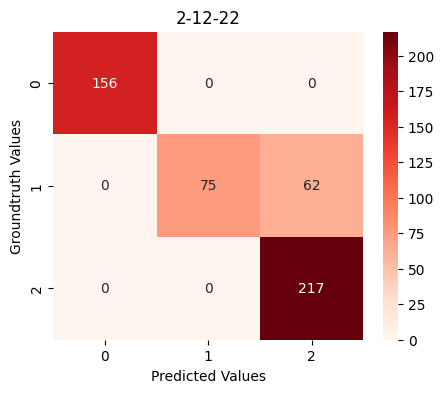

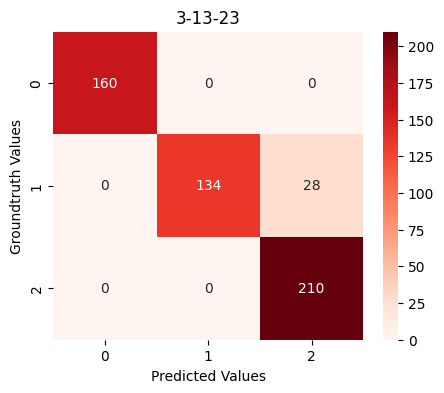

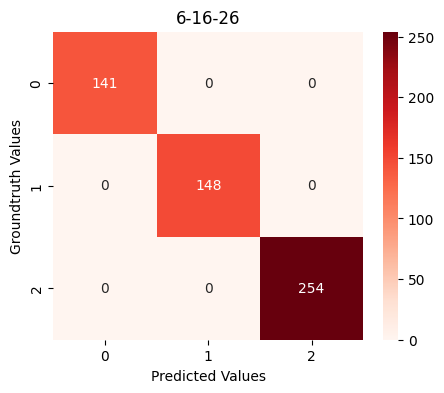

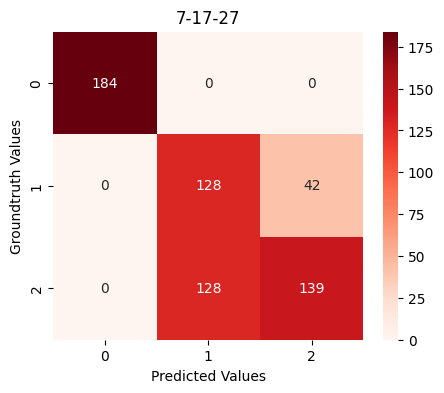

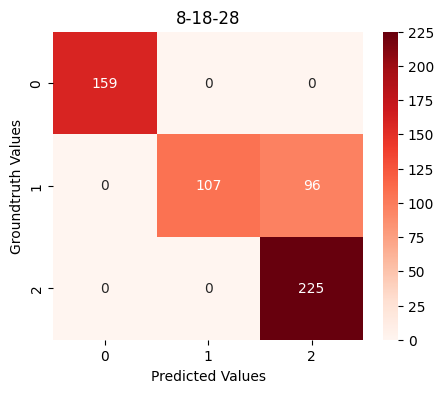

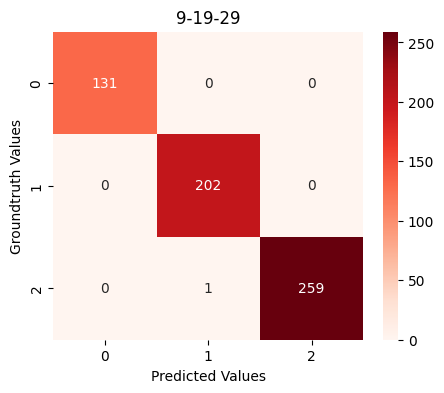

In [3]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(df, num_classes=3):
    # Parse
    y_test = df['label'].values
    y_pred = df.loc[:, [f'Class_{c}_score' for c in range(num_classes)]].to_numpy().argmax(axis=1)

    return confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))

for score_csv, _ in sorted(csv_fpaths, key=lambda x:x[1]):
    df = pd.read_csv(score_csv)
    round_id = re.search(r'\d+-\d+-*\d*', score_csv).group()

    # confusion matrix
    cm = calculate_confusion_matrix(df, n_classes)

    # df
    cm_df = pd.DataFrame(cm,
        index=[c for c in range(n_classes)],
        columns=[c for c in range(n_classes)])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap=plt.cm.Reds)
    plt.title(round_id)
    plt.ylabel('Groundtruth Values')
    plt.xlabel('Predicted Values')
    plt.show()

# 2. Accuracy

In [4]:
def calculate_accuracy(df, num_classes=3, average='macro'):
    assert average in [None, 'micro', 'macro', 'weighted']
    y_test = df['label'].values
    y_pred = df.loc[:, [f'Class_{c}_score' for c in range(num_classes)]] \
        .to_numpy().argmax(axis=1)

    # accuracy, precision, recall, f1-score
    acc = metrics.accuracy_score(
        y_true=y_test,
        y_pred=y_pred, normalize=True)

    p = metrics.precision_score(
        y_true=y_test,
        y_pred=y_pred, average=average)

    r = metrics.recall_score(
        y_true=y_test,
        y_pred=y_pred, average=average)

    f1 = metrics.f1_score(
        y_true=y_test,
        y_pred=y_pred, average=average)

    return acc, p, r, f1

In [5]:
tmp = []
cols = ['ID', 'Accuracy', 'Precision', 'Recall', 'F1']
for score_csv, _ in sorted(csv_fpaths, key=lambda x:x[1]):
    df = pd.read_csv(score_csv)

    round_id = re.search(r'\d+-\d+-\d+', score_csv).group()

    acc, p, r, f1 = calculate_accuracy(df, n_classes)
    # acc = np.mean(list(acc.values()))
    print(f'{round_id}')
    print(f"\tAccuracy: {acc:.3f}")
    print(f"\tPrecision: {p:.3f}")
    print(f"\tRecall: {r:.3f}")
    print(f"\tF1: {f1:.3f}")
    tmp.append( [
        round_id,
        round(acc, 3),
        round(p, 3),
        round(r, 3),
        round(f1, 3)] )

tmp_df = pd.DataFrame(tmp, columns=cols)
print(f"Accuracy: {tmp_df['Accuracy'].mean():.3f} +- {tmp_df['Accuracy'].std():.3f}")
print(f"Precision: {tmp_df['Precision'].mean():.3f} +- {tmp_df['Precision'].std():.3f}")
print(f"Recall: {tmp_df['Recall'].mean():.3f} +- {tmp_df['Recall'].std():.3f}")
print(f"F1: {tmp_df['F1'].mean():.3f} +- {tmp_df['F1'].std():.3f}")

tmp_df.to_excel("tmp.xlsx",
    sheet_name='Sheet1',
    columns=cols)

2-12-22
	Accuracy: 0.878
	Precision: 0.926
	Recall: 0.849
	F1: 0.861
3-13-23
	Accuracy: 0.947
	Precision: 0.961
	Recall: 0.942
	F1: 0.948
6-16-26
	Accuracy: 1.000
	Precision: 1.000
	Recall: 1.000
	F1: 1.000
7-17-27
	Accuracy: 0.726
	Precision: 0.756
	Recall: 0.758
	F1: 0.740
8-18-28
	Accuracy: 0.836
	Precision: 0.900
	Recall: 0.842
	F1: 0.838
9-19-29
	Accuracy: 0.998
	Precision: 0.998
	Recall: 0.999
	F1: 0.999
Accuracy: 0.898 +- 0.106
Precision: 0.924 +- 0.091
Recall: 0.898 +- 0.098
F1: 0.898 +- 0.103


# 3. AUC

In [6]:
my_dict = {
    0: "Dry hair",
    1: "Applied Shampoo Hair",
    2: "Applied Cream Hair",
}

def calculate_auc_ovr(df, num_classes=3):
    fpr, tpr, threshold = dict(), dict(), dict()
    roc_auc_ovr = dict()

    # plot
    plt.figure(figsize=(20, 10))

    for c in range(num_classes):
        # Convert to binary classification
        df_aux = pd.DataFrame()
        df_aux['y_true'] = df['label'].apply(lambda x: 1 if x==c else 0)
        df_aux['y_hat'] = df[f'Class_{c}_score']

        # Compute auc
        fpr[c], tpr[c], threshold[c] = roc_curve(
            y_true=df_aux['y_true'],
            y_score=df_aux['y_hat'])
        roc_auc_ovr[c] = auc(x=fpr[c], y=tpr[c])

        # Plot probability distribution current class vs rest
        ax_top = plt.subplot(2, num_classes, c+1)
        sns.histplot(data=df_aux,
            x='y_hat', hue='y_true',
            color='b', ax=ax_top, bins=50)
        ax_top.set_title(c)
        ax_top.legend([f"Class: {c}", "Rest"])
        ax_top.set_xlabel(f"P(x = {c})")

        # Plots the ROC Curves
        ax_bottom = plt.subplot(2, num_classes, c+num_classes+1)
        plt.plot(fpr[c], tpr[c], label='ROC curve class %d (area = %0.2f)' % (c, roc_auc_ovr[c]))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

    plt.savefig(f'DATA/plot/AUC.png', dpi=600, bbox_inches='tight', facecolor='white')
    return fpr, tpr, roc_auc_ovr

In [7]:
# def calculate_auc_ovo(df, num_classes=3):
#     roc_auc_ovo = dict()
#     fpr, tpr, threshold = dict(), dict(), dict()
    
#     # plot
#     plt.figure(figsize=(20, 15))
    
#     # permutations
#     classes_permutations = list(permutations(np.arange(num_classes), 2))
#     N = len(classes_permutations)

#     for i, (c1, c2) in enumerate(classes_permutations):
#         title = f"Class {c1} vs Class {c2}"
#         df_aux = pd.DataFrame()
#         df_aux['label'] = df['label']
#         df_aux['y_hat'] = df[f'Class_{c1}_score']
        
#         # Slices only the subset with both classes
#         df_aux = df_aux[
#             (df_aux['label'] == c1) | (df_aux['label'] == c2)]

#         # Convert to Binary Classification
#         df_aux['y_true'] = df_aux['label'].apply(lambda x: 1 if x==c1 else 0)
#         df_aux = df_aux.reset_index(drop = True)

#         # Compute auc
#         fpr[title], tpr[title], threshold[title] = roc_curve(
#             y_true=df_aux['y_true'],
#             y_score=df_aux['y_hat'])
#         roc_auc_ovo[title] = auc(x=fpr[title], y=tpr[title])

#         # Plots the probability distribution for c1 vs c2
#         ax_top = plt.subplot(2, N, i+1)
#         sns.histplot(data=df_aux,
#              x='y_hat', hue='y_true',
#             color='b', ax=ax_top, bins=20)
#         ax_top.set_title(title)
#         ax_top.legend([f"Class {c1}", f"Class {c2}"])
#         ax_top.set_xlabel(f"P(x = {c1})")

#         # Plots the ROC Curves
#         ax_bottom = plt.subplot(2, N, i+N+1)
#         plt.plot(fpr[title], tpr[title])
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlim([-0.05, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')

#     return fpr, tpr, roc_auc_ovo

In [8]:
# Paper plot
my_dict = {
    0: "Dry hair",
    1: "Applied Shampoo Hair",
    2: "Applied Cream Hair",
}
def calculate_auc_ovo(df, num_classes=3):
    roc_auc_ovo = dict()
    fpr, tpr, threshold = dict(), dict(), dict()

    # plot
    # plt.figure(figsize=(20, 15), sharey=True)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.15)
    # permutations
    classes_permutations = [ (0,1), (0,2) ]
    N = 2

    for i, (c1, c2) in enumerate(classes_permutations):
        title = f"{my_dict[c1]} vs {my_dict[c2]}"
        df_aux = pd.DataFrame()
        df_aux['label'] = df['label']
        df_aux['y_hat'] = df[f'Class_{c1}_score']

        # Slices only the subset with both classes
        df_aux = df_aux[
            (df_aux['label'] == c1) | (df_aux['label'] == c2)]

        # Convert to Binary Classification
        df_aux['y_true'] = df_aux['label'].apply(lambda x: 1 if x==c1 else 0)
        df_aux = df_aux.reset_index(drop = True)

        # Compute auc
        fpr[title], tpr[title], threshold[title] = roc_curve(
            y_true=df_aux['y_true'],
            y_score=df_aux['y_hat'])
        roc_auc_ovo[title] = auc(x=fpr[title], y=tpr[title])

        # Plots the probability distribution for c1 vs c2
        sns.histplot(data=df_aux,
             x='y_hat', hue='y_true',
            color='b', ax=axs[0,i], bins=20)
        axs[0,i].set_xlabel(f"LogSoftmax output")
        axs[0,i].set_title(title)
        axs[0,i].legend([my_dict[c1], my_dict[c2]])

        # Plots the ROC Curves
        axs[1,i].plot(fpr[title], tpr[title])
        axs[1,i].plot([0, 1], [0, 1], 'k--')
        axs[1,i].set_xlim([-0.05, 1.0])
        axs[1,i].set_ylim([0.0, 1.05])
        axs[1,i].set_xlabel('False Positive Rate')
        axs[1,i].set_ylabel('True Positive Rate')
        axs[1,i].legend(["AUC ovo = 1.0"])
    fig.savefig(f'DATA/plot/AUC_ovo.png', dpi=450, bbox_inches='tight', facecolor='white')
    return fpr, tpr, roc_auc_ovo

In [9]:
# Paper plot
my_dict = {
    0: "Dry hair",
    1: "Applied Shampoo Hair",
    2: "Applied Cream Hair",
}
def calculate_auc_ovo(df, num_classes=3):
    roc_auc_ovo = dict()
    fpr, tpr, threshold = dict(), dict(), dict()

    # plot
    # plt.figure(figsize=(20, 15), sharey=True)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
    plt.subplots_adjust(wspace=0.06, hspace=0.15)
    # permutations
    classes_permutations = [ (0,1), (0,2) ]
    N = 2

    for i, (c1, c2) in enumerate(classes_permutations):
        title = f"{my_dict[c1]} vs {my_dict[c2]}"
        df_aux = pd.DataFrame()
        df_aux['label'] = df['label']
        df_aux['y_hat'] = df[f'Class_{c1}_score']

        # Slices only the subset with both classes
        df_aux = df_aux[
            (df_aux['label'] == c1) | (df_aux['label'] == c2)]

        # Convert to Binary Classification
        df_aux['y_true'] = df_aux['label'].apply(lambda x: 1 if x==c1 else 0)
        df_aux = df_aux.reset_index(drop = True)

        # Compute auc
        fpr[title], tpr[title], threshold[title] = roc_curve(
            y_true=df_aux['y_true'],
            y_score=df_aux['y_hat'])
        roc_auc_ovo[title] = auc(x=fpr[title], y=tpr[title])

        # Plots the probability distribution for c1 vs c2
        sns.histplot(data=df_aux,
             x='y_hat', hue='y_true',
            color='b', ax=axs[i], bins=20)
        axs[i].set_xlabel(f"LogSoftmax output")
        axs[i].set_ylabel('Sample Count')
        axs[i].set_title(title)
        axs[i].legend([my_dict[c1], my_dict[c2]])


        # Plots the ROC Curves
        # axs[1,i].plot(fpr[title], tpr[title])
        # axs[1,i].plot([0, 1], [0, 1], 'k--')
        # axs[1,i].set_xlim([-0.05, 1.0])
        # axs[1,i].set_ylim([0.0, 1.05])
        # axs[1,i].set_xlabel('False Positive Rate')
        # axs[1,i].set_ylabel('True Positive Rate')
        # axs[1,i].legend(["AUC ovo = 1.0"])
    fig.savefig(f'DATA/plot/AUC_ovo_2.png', dpi=550, bbox_inches='tight', facecolor='white')
    return fpr, tpr, roc_auc_ovo

In [10]:
df_s = []
for score_csv, _ in sorted(csv_fpaths, key=lambda x:x[1]):
    df_s.append(pd.read_csv(score_csv))
df = pd.concat(df_s, ignore_index=True)

{0: 1.0, 1: 0.9320929400896024, 2: 0.9390572022429393}
Average per-class AUC OvR: 0.96


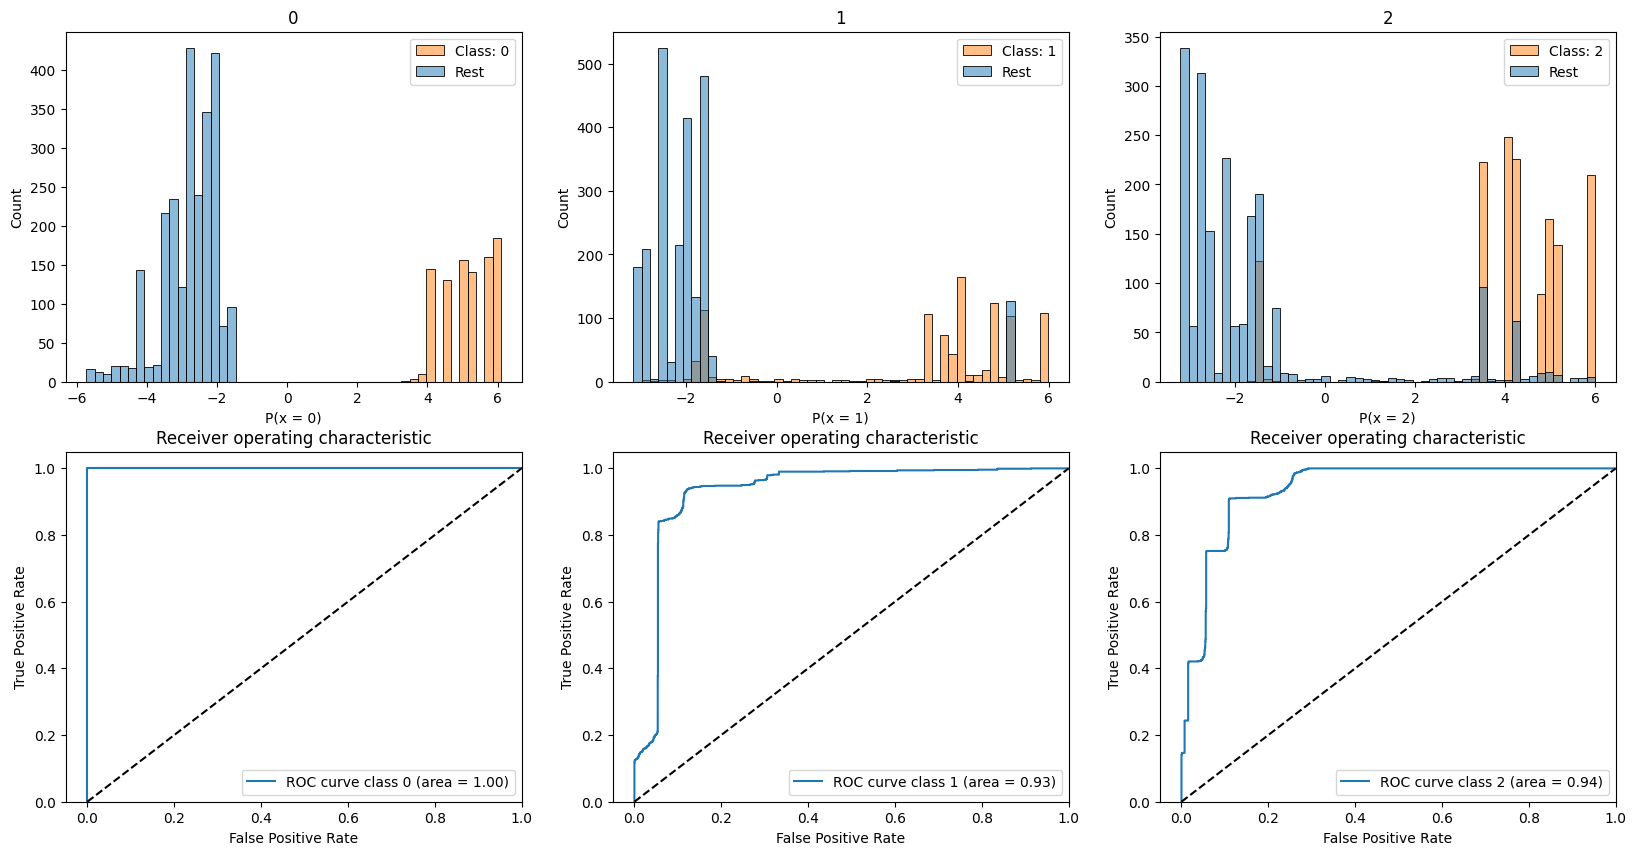

In [11]:
fpr, tpr, roc_auc = calculate_auc_ovr(df, n_classes)
pprint(roc_auc)
print(f"Average per-class AUC OvR: {np.mean(list(roc_auc.values())):.2f}")

In [12]:
# fpr, tpr, roc_auc = calculate_auc_ovo(df, n_classes)
# pprint(roc_auc)
# print("Average per-class AUC OvO:", np.mean(list(roc_auc.values())))